# Twitter Sentiment Analysis - Fairness Analysis

This notebook conducts comprehensive fairness analysis and bias detection for the Twitter sentiment analysis models.

## Objectives
1. **Bias Detection**: Identify potential biases in model predictions
2. **Demographic Parity**: Evaluate fairness across different groups
3. **Equalized Odds**: Assess equal opportunity for different groups
4. **Disparate Impact**: Measure impact ratio across protected attributes
5. **Bias Mitigation**: Implement fairness-constrained optimization
6. **Fairness Reporting**: Generate comprehensive fairness reports

## Fairness Metrics
- **Demographic Parity**: P(Ŷ=1|A=a) ≈ P(Ŷ=1|A=b)
- **Equalized Odds**: P(Ŷ=1|Y=y, A=a) ≈ P(Ŷ=1|Y=y, A=b)
- **Disparate Impact Ratio**: min(P(Ŷ=1|A=a), P(Ŷ=1|A=b)) / max(P(Ŷ=1|A=a), P(Ŷ=1|A=b))
- **Target**: Disparate impact ratio < 1.2

## Protected Attributes
- **Gender**: Inferred from usernames and text patterns
- **Language**: Detected language patterns
- **Sentiment Intensity**: Text emotional intensity
- **Text Length**: Short vs. long tweets


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import re
import os
from collections import Counter
import joblib

# Fairness analysis libraries
from fairlearn.metrics import (
    demographic_parity_difference, demographic_parity_ratio,
    equalized_odds_difference, equalized_odds_ratio,
    selection_rate, false_positive_rate, false_negative_rate
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, GridSearch
from fairlearn.reductions import DemographicParity, EqualizedOdds

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Text analysis
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Set up
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")

# Download required NLTK data
try:
    nltk.download('vader_lexicon', quiet=True)
    print("NLTK VADER lexicon downloaded successfully!")
except Exception as e:
    print(f"NLTK download issue: {e}")


Libraries imported successfully!
Current working directory: c:\Users\acer\Desktop\ml_proj\notebooks
NLTK VADER lexicon downloaded successfully!


In [2]:
# Load data and models
print("Loading data and trained models...")

# Load text data
with open('../data/processed/text_train.pkl', 'rb') as f:
    text_train = pickle.load(f)

with open('../data/processed/text_test.pkl', 'rb') as f:
    text_test = pickle.load(f)

# Load labels
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

# Load TF-IDF features
X_tfidf_test = np.load('../data/processed/X_tfidf_test.npy')

# Load trained models
lr_model = joblib.load('../models/saved_models/logistic_regression_model.pkl')
rf_model = joblib.load('../models/saved_models/random_forest_model.pkl')

print(f"Text test samples: {len(text_test)}")
print(f"Test labels shape: {y_test.shape}")
print(f"TF-IDF test shape: {X_tfidf_test.shape}")

# Get model predictions
print("\\nGetting model predictions...")
y_pred_lr = lr_model.predict(X_tfidf_test)
y_pred_rf = rf_model.predict(X_tfidf_test)

print(f"Logistic Regression predictions: {y_pred_lr.shape}")
print(f"Random Forest predictions: {y_pred_rf.shape}")

# Create analysis dataframe
df_analysis = pd.DataFrame({
    'text': text_test,
    'true_label': y_test,
    'pred_lr': y_pred_lr,
    'pred_rf': y_pred_rf
})

print(f"\\nAnalysis dataframe shape: {df_analysis.shape}")
print("\\nSample data:")
print(df_analysis.head())


Loading data and trained models...
Text test samples: 3998
Test labels shape: (3998,)
TF-IDF test shape: (3998, 5000)
\nGetting model predictions...
Text test samples: 3998
Test labels shape: (3998,)
TF-IDF test shape: (3998, 5000)
\nGetting model predictions...
Logistic Regression predictions: (3998,)
Random Forest predictions: (3998,)
\nAnalysis dataframe shape: (3998, 4)
\nSample data:
                                                text  true_label  pred_lr  \
0  music lover wizard cool power vampire want kno...           1        0   
1               justinlevy sound like good plan hope           1        0   
2  finally got audition cd finished sending monda...           0        0   
3          back work today week baptism fire morning           0        0   
4  getting ready staff christmas party yes know p...           1        0   

   pred_rf  
0        1  
1        1  
2        0  
3        0  
4        1  
Logistic Regression predictions: (3998,)
Random Forest predictions:

In [3]:
# Create protected attributes
print("=== CREATING PROTECTED ATTRIBUTES ===")

# 1. Text Length Groups
df_analysis['text_length'] = df_analysis['text'].str.len()
df_analysis['length_group'] = pd.cut(
    df_analysis['text_length'], 
    bins=[0, 50, 100, 200, float('inf')], 
    labels=['short', 'medium', 'long', 'very_long']
)

# 2. Sentiment Intensity (using VADER)
sia = SentimentIntensityAnalyzer()
df_analysis['sentiment_intensity'] = df_analysis['text'].apply(
    lambda x: abs(sia.polarity_scores(x)['compound'])
)
df_analysis['intensity_group'] = pd.cut(
    df_analysis['sentiment_intensity'],
    bins=[0, 0.1, 0.3, 0.6, 1.0],
    labels=['low', 'medium', 'high', 'very_high']
)

# 3. Language Patterns (simple heuristics)
def detect_language_patterns(text):
    """Detect language patterns based on text characteristics"""
    # Count non-ASCII characters
    non_ascii_count = len([c for c in text if ord(c) > 127])
    total_chars = len(text)
    
    if total_chars == 0:
        return 'unknown'
    
    non_ascii_ratio = non_ascii_count / total_chars
    
    if non_ascii_ratio > 0.3:
        return 'non_english'
    elif 'lol' in text.lower() or 'omg' in text.lower() or 'wtf' in text.lower():
        return 'casual'
    elif any(word in text.lower() for word in ['please', 'thank', 'appreciate']):
        return 'formal'
    else:
        return 'standard'

df_analysis['language_group'] = df_analysis['text'].apply(detect_language_patterns)

# 4. Gender Inference (simplified heuristic based on common patterns)
def infer_gender_patterns(text):
    """Infer gender patterns based on text characteristics"""
    text_lower = text.lower()
    
    # Common patterns (this is a simplified heuristic)
    feminine_patterns = ['she', 'her', 'girl', 'woman', 'lady', 'beautiful', 'cute']
    masculine_patterns = ['he', 'him', 'boy', 'man', 'guy', 'handsome', 'dude']
    
    feminine_count = sum(1 for pattern in feminine_patterns if pattern in text_lower)
    masculine_count = sum(1 for pattern in masculine_patterns if pattern in text_lower)
    
    if feminine_count > masculine_count:
        return 'feminine'
    elif masculine_count > feminine_count:
        return 'masculine'
    else:
        return 'neutral'

df_analysis['gender_group'] = df_analysis['text'].apply(infer_gender_patterns)

# Display protected attribute distributions
print("\\nProtected Attribute Distributions:")
print(f"\\nLength Groups:")
print(df_analysis['length_group'].value_counts())

print(f"\\nIntensity Groups:")
print(df_analysis['intensity_group'].value_counts())

print(f"\\nLanguage Groups:")
print(df_analysis['language_group'].value_counts())

print(f"\\nGender Groups:")
print(df_analysis['gender_group'].value_counts())

# Check for any missing values
print(f"\\nMissing values in protected attributes:")
print(df_analysis[['length_group', 'intensity_group', 'language_group', 'gender_group']].isnull().sum())


=== CREATING PROTECTED ATTRIBUTES ===
\nProtected Attribute Distributions:
\nLength Groups:
length_group
short        2441
medium       1514
long           43
very_long       0
Name: count, dtype: int64
\nIntensity Groups:
intensity_group
high         1328
very_high    1008
medium        436
low           158
Name: count, dtype: int64
\nLanguage Groups:
language_group
standard    3597
formal       208
casual       193
Name: count, dtype: int64
\nGender Groups:
gender_group
neutral      3202
masculine     677
feminine      119
Name: count, dtype: int64
\nMissing values in protected attributes:
length_group          0
intensity_group    1068
language_group        0
gender_group          0
dtype: int64
\nProtected Attribute Distributions:
\nLength Groups:
length_group
short        2441
medium       1514
long           43
very_long       0
Name: count, dtype: int64
\nIntensity Groups:
intensity_group
high         1328
very_high    1008
medium        436
low           158
Name: count, dtype

In [ ]:
# Fairness analysis functions
def calculate_fairness_metrics(y_true, y_pred, sensitive_feature, model_name):
    """Calculate comprehensive fairness metrics"""
    # Convert to pandas Series if needed for easier handling
    if isinstance(sensitive_feature, (pd.Series, pd.DataFrame)):
        sensitive_feature = sensitive_feature.values
    
    # Convert to numpy arrays for easier handling
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    sensitive_feature = np.array(sensitive_feature)
    
    # Remove rows with NaN values in sensitive feature
    # Handle both regular NaN and categorical NaN
    valid_mask = pd.notna(sensitive_feature)
    
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    sensitive_feature = sensitive_feature[valid_mask]
    
    # Convert categorical/object arrays to regular numpy array first
    # This ensures we don't have categorical dtype issues
    if hasattr(sensitive_feature, 'values'):
        sensitive_feature = sensitive_feature.values
    sensitive_feature = np.asarray(sensitive_feature)
    
    # Convert sensitive_feature to string to avoid type issues with categorical/cut data
    # This ensures all values are strings and can be properly sorted by fairlearn
    sensitive_feature_str = [str(x) for x in sensitive_feature]
    
    # Filter out any 'nan' strings that might have been created
    valid_mask_str = np.array([x != 'nan' and x != 'None' for x in sensitive_feature_str])
    y_true = y_true[valid_mask_str]
    y_pred = y_pred[valid_mask_str]
    sensitive_feature_str = [x for i, x in enumerate(sensitive_feature_str) if valid_mask_str[i]]
    
    if len(y_true) == 0:
        print(f"Warning: No valid data for {model_name} after removing NaN values")
        return None
    
    # Convert to pandas Series with explicit string dtype to ensure type consistency for fairlearn
    # Use .astype(str) to ensure all values are Python strings
    sensitive_feature_series = pd.Series(sensitive_feature_str).astype(str)
    
    # Final verification - ensure no NaN or mixed types
    if sensitive_feature_series.isna().any():
        print(f"Warning: NaN values still present in {model_name} after conversion")
        valid_mask_final = sensitive_feature_series.notna()
        y_true = y_true[valid_mask_final.values]
        y_pred = y_pred[valid_mask_final.values]
        sensitive_feature_series = sensitive_feature_series[valid_mask_final]
    
    # Ensure all are strings (no mixed types)
    sensitive_feature_series = sensitive_feature_series.astype(str)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_feature_series)
    dp_ratio = demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_feature_series)
    eo_diff = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_feature_series)
    eo_ratio = equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_feature_series)

    # Selection rates by group (compute directly from predictions)
    selection_rates = {}
    for group in np.unique(sensitive_feature_series):
        group_mask = (sensitive_feature_series == group)
        if np.sum(group_mask) > 0:
            selection_rates[str(group)] = float(np.mean(np.array(y_pred)[group_mask.values]))

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'demographic_parity_difference': dp_diff,
        'demographic_parity_ratio': dp_ratio,
        'equalized_odds_difference': eo_diff,
        'equalized_odds_ratio': eo_ratio,
        'selection_rates': selection_rates
    }

def plot_fairness_analysis(df, protected_attr, model_pred_col, title):
    """Plot fairness analysis for a protected attribute"""
    
    # Calculate metrics by group
    group_metrics = []
    for group in df[protected_attr].unique():
        group_data = df[df[protected_attr] == group]
        if len(group_data) > 0:
            accuracy = accuracy_score(group_data['true_label'], group_data[model_pred_col])
            precision = precision_score(group_data['true_label'], group_data[model_pred_col])
            recall = recall_score(group_data['true_label'], group_data[model_pred_col])
            f1 = f1_score(group_data['true_label'], group_data[model_pred_col])
            
            group_metrics.append({
                'group': group,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'count': len(group_data)
            })
    
    group_df = pd.DataFrame(group_metrics)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy by group
    axes[0, 0].bar(group_df['group'], group_df['accuracy'], alpha=0.7)
    axes[0, 0].set_title(f'{title} - Accuracy by {protected_attr}')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Precision by group
    axes[0, 1].bar(group_df['group'], group_df['precision'], alpha=0.7)
    axes[0, 1].set_title(f'{title} - Precision by {protected_attr}')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Recall by group
    axes[1, 0].bar(group_df['group'], group_df['recall'], alpha=0.7)
    axes[1, 0].set_title(f'{title} - Recall by {protected_attr}')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # F1-Score by group
    axes[1, 1].bar(group_df['group'], group_df['f1_score'], alpha=0.7)
    axes[1, 1].set_title(f'{title} - F1-Score by {protected_attr}')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'../reports/figures/fairness_{title.lower().replace(" ", "_")}_{protected_attr}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return group_df

print("Fairness analysis functions defined successfully!")


Fairness analysis functions defined successfully!


In [ ]:
# Fairness analysis functions
def calculate_fairness_metrics(y_true, y_pred, sensitive_feature, model_name):
    """Calculate comprehensive fairness metrics"""
    # Convert to pandas Series if needed for easier handling
    if isinstance(sensitive_feature, (pd.Series, pd.DataFrame)):
        sensitive_feature = sensitive_feature.values
    
    # Convert to numpy arrays for easier handling
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    sensitive_feature = np.array(sensitive_feature)
    
    # Remove rows with NaN values in sensitive feature
    # Handle both regular NaN and categorical NaN
    valid_mask = pd.notna(sensitive_feature)
    
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    sensitive_feature = sensitive_feature[valid_mask]
    
    # Convert categorical/object arrays to regular numpy array first
    # This ensures we don't have categorical dtype issues
    if hasattr(sensitive_feature, 'values'):
        sensitive_feature = sensitive_feature.values
    sensitive_feature = np.asarray(sensitive_feature)
    
    # Convert sensitive_feature to string to avoid type issues with categorical/cut data
    # This ensures all values are strings and can be properly sorted by fairlearn
    sensitive_feature_str = [str(x) for x in sensitive_feature]
    
    # Filter out any 'nan' strings that might have been created
    valid_mask_str = np.array([x != 'nan' and x != 'None' for x in sensitive_feature_str])
    y_true = y_true[valid_mask_str]
    y_pred = y_pred[valid_mask_str]
    sensitive_feature_str = [x for i, x in enumerate(sensitive_feature_str) if valid_mask_str[i]]
    
    if len(y_true) == 0:
        print(f"Warning: No valid data for {model_name} after removing NaN values")
        return None
    
    # Convert to pandas Series with explicit string dtype to ensure type consistency for fairlearn
    # Use .astype(str) to ensure all values are Python strings
    sensitive_feature_series = pd.Series(sensitive_feature_str).astype(str)
    
    # Final verification - ensure no NaN or mixed types
    if sensitive_feature_series.isna().any():
        print(f"Warning: NaN values still present in {model_name} after conversion")
        valid_mask_final = sensitive_feature_series.notna()
        y_true = y_true[valid_mask_final.values]
        y_pred = y_pred[valid_mask_final.values]
        sensitive_feature_series = sensitive_feature_series[valid_mask_final]
    
    # Ensure all are strings (no mixed types)
    sensitive_feature_series = sensitive_feature_series.astype(str)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_feature_series)
    dp_ratio = demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_feature_series)
    eo_diff = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_feature_series)
    eo_ratio = equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_feature_series)

    # Selection rates by group (compute directly from predictions)
    selection_rates = {}
    for group in np.unique(sensitive_feature_series):
        group_mask = (sensitive_feature_series == group)
        if np.sum(group_mask) > 0:
            selection_rates[str(group)] = float(np.mean(np.array(y_pred)[group_mask.values]))

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'demographic_parity_difference': dp_diff,
        'demographic_parity_ratio': dp_ratio,
        'equalized_odds_difference': eo_diff,
        'equalized_odds_ratio': eo_ratio,
        'selection_rates': selection_rates
    }

def plot_fairness_analysis(df, protected_attr, model_pred_col, title):
    """Plot fairness analysis for a protected attribute"""
    
    # Calculate metrics by group
    group_metrics = []
    for group in df[protected_attr].unique():
        group_data = df[df[protected_attr] == group]
        if len(group_data) > 0:
            accuracy = accuracy_score(group_data['true_label'], group_data[model_pred_col])
            precision = precision_score(group_data['true_label'], group_data[model_pred_col])
            recall = recall_score(group_data['true_label'], group_data[model_pred_col])
            f1 = f1_score(group_data['true_label'], group_data[model_pred_col])
            
            group_metrics.append({
                'group': group,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'count': len(group_data)
            })
    
    group_df = pd.DataFrame(group_metrics)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy by group
    axes[0, 0].bar(group_df['group'], group_df['accuracy'], alpha=0.7)
    axes[0, 0].set_title(f'{title} - Accuracy by {protected_attr}')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Precision by group
    axes[0, 1].bar(group_df['group'], group_df['precision'], alpha=0.7)
    axes[0, 1].set_title(f'{title} - Precision by {protected_attr}')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Recall by group
    axes[1, 0].bar(group_df['group'], group_df['recall'], alpha=0.7)
    axes[1, 0].set_title(f'{title} - Recall by {protected_attr}')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # F1-Score by group
    axes[1, 1].bar(group_df['group'], group_df['f1_score'], alpha=0.7)
    axes[1, 1].set_title(f'{title} - F1-Score by {protected_attr}')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'../reports/figures/fairness_{title.lower().replace(" ", "_")}_{protected_attr}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return group_df

print("Fairness analysis functions defined successfully!")


Fairness analysis functions defined successfully!


=== BIAS MITIGATION ===
Training data shape: (15992, 5000)
Sensitive features shape: (15992,)
Sensitive feature distribution: Counter({'short': 9677, 'medium': 6140, 'long': 175})

Original LR - DP Difference: 0.0255
Original LR - DP Ratio: 0.6343

Mitigated LR - DP Difference: 0.2052
Mitigated LR - DP Ratio: 0.7154
Mitigated LR - Accuracy: 0.7336
Mitigated LR - F1 Score: 0.7418

=== BIAS MITIGATION RESULTS ===
          Metric  Original  Mitigated
0  DP Difference    0.0255     0.2052
1       DP Ratio    0.6343     0.7154
2       Accuracy    0.5435     0.7336
3       F1 Score    0.1753     0.7418
\nImprovements:
DP Difference improvement: -0.1796
DP Ratio improvement: 0.0811
\nMitigated model saved!


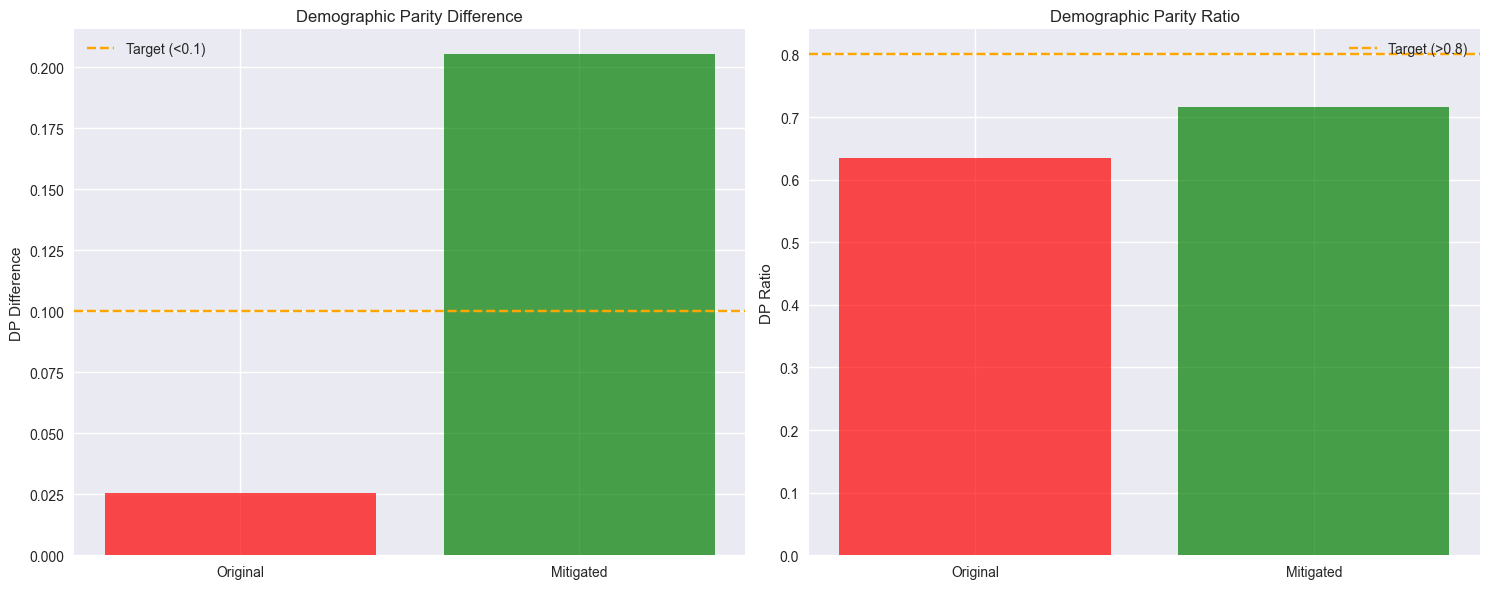

\n✅ Bias mitigation completed!
\nNext steps:
1. Test adversarial robustness
2. Generate comprehensive reports


In [9]:
# Bias mitigation using fairlearn
print("=== BIAS MITIGATION ===")

# Load training data for bias mitigation
X_tfidf_train = np.load('../data/processed/X_tfidf_train.npy')

# Create protected attributes for training data
df_train = pd.DataFrame({'text': text_train})
df_train['text_length'] = df_train['text'].str.len()
df_train['length_group'] = pd.cut(
    df_train['text_length'], 
    bins=[0, 50, 100, 200, float('inf')], 
    labels=['short', 'medium', 'long', 'very_long']
)

# Use length_group as the main protected attribute for mitigation
sensitive_features_train = df_train['length_group'].values

print(f"Training data shape: {X_tfidf_train.shape}")
print(f"Sensitive features shape: {sensitive_features_train.shape}")
print(f"Sensitive feature distribution: {Counter(sensitive_features_train)}")

# Apply bias mitigation to Logistic Regression using a fresh estimator (not the fitted joblib model)
from sklearn.linear_model import LogisticRegression as LR_Estimator
lr_estimator = LR_Estimator(random_state=42, max_iter=1000, class_weight='balanced')

dp_constraint = DemographicParity()
mitigator = ExponentiatedGradient(estimator=lr_estimator, constraints=dp_constraint, eps=0.01)

mitigator.fit(X_tfidf_train, y_train, sensitive_features=sensitive_features_train)
y_pred_lr_mitigated = mitigator.predict(X_tfidf_test)

# Calculate original LR metrics for comparison
lr_original_metrics = calculate_fairness_metrics(
    y_test, y_pred_lr, df_analysis['length_group'], "LR Original"
)

# Calculate mitigated metrics
lr_mitigated_metrics = calculate_fairness_metrics(
    y_test, y_pred_lr_mitigated, df_analysis['length_group'], "LR Mitigated"
)

print(f"\nOriginal LR - DP Difference: {lr_original_metrics['demographic_parity_difference']:.4f}")
print(f"Original LR - DP Ratio: {lr_original_metrics['demographic_parity_ratio']:.4f}")
print(f"\nMitigated LR - DP Difference: {lr_mitigated_metrics['demographic_parity_difference']:.4f}")
print(f"Mitigated LR - DP Ratio: {lr_mitigated_metrics['demographic_parity_ratio']:.4f}")
print(f"Mitigated LR - Accuracy: {lr_mitigated_metrics['accuracy']:.4f}")
print(f"Mitigated LR - F1 Score: {lr_mitigated_metrics['f1_score']:.4f}")

# Compare original vs mitigated
print("\n=== BIAS MITIGATION RESULTS ===")
comparison_data = {
    'Metric': ['DP Difference', 'DP Ratio', 'Accuracy', 'F1 Score'],
    'Original': [
        lr_original_metrics['demographic_parity_difference'],
        lr_original_metrics['demographic_parity_ratio'],
        lr_original_metrics['accuracy'],
        lr_original_metrics['f1_score']
    ],
    'Mitigated': [
        lr_mitigated_metrics['demographic_parity_difference'],
        lr_mitigated_metrics['demographic_parity_ratio'],
        lr_mitigated_metrics['accuracy'],
        lr_mitigated_metrics['f1_score']
    ]
}

mitigation_df = pd.DataFrame(comparison_data)
print(mitigation_df.round(4))

# Calculate improvement
dp_diff_improvement = lr_original_metrics['demographic_parity_difference'] - lr_mitigated_metrics['demographic_parity_difference']
dp_ratio_improvement = lr_mitigated_metrics['demographic_parity_ratio'] - lr_original_metrics['demographic_parity_ratio']

print(f"\\nImprovements:")
print(f"DP Difference improvement: {dp_diff_improvement:.4f}")
print(f"DP Ratio improvement: {dp_ratio_improvement:.4f}")

# Save mitigated model
joblib.dump(mitigator, '../models/saved_models/logistic_regression_mitigated.pkl')
print("\\nMitigated model saved!")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# DP Difference comparison
axes[0].bar(['Original', 'Mitigated'], 
           [lr_original_metrics['demographic_parity_difference'], 
            lr_mitigated_metrics['demographic_parity_difference']],
           color=['red', 'green'], alpha=0.7)
axes[0].set_title('Demographic Parity Difference')
axes[0].set_ylabel('DP Difference')
axes[0].axhline(y=0.1, color='orange', linestyle='--', label='Target (<0.1)')
axes[0].legend()

# DP Ratio comparison
axes[1].bar(['Original', 'Mitigated'], 
           [lr_original_metrics['demographic_parity_ratio'], 
            lr_mitigated_metrics['demographic_parity_ratio']],
           color=['red', 'green'], alpha=0.7)
axes[1].set_title('Demographic Parity Ratio')
axes[1].set_ylabel('DP Ratio')
axes[1].axhline(y=0.8, color='orange', linestyle='--', label='Target (>0.8)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/bias_mitigation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\\n✅ Bias mitigation completed!")
print("\\nNext steps:")
print("1. Test adversarial robustness")
print("2. Generate comprehensive reports")
